# Deep Convolutional GANs

Jun Zhu

---

The DCGAN architecture was [first]((https://arxiv.org/pdf/1511.06434.pdf) explored in 2016 and has seen impressive results in generating new images.

In this project, we will train a DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![](images/svhn_gan.png)


In [1]:
%matplotlib inline

import os
import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

print("Tensorflow version is {}".format(tf.__version__))

/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Tensorflow version is 1.4.0


## SVHN Data
### Download data

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

try:
    os.mkdir(data_dir)
except OSError:
    pass

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [3]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

### Visualization

Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

Number of training data: 73257
Number of testing data: 26032


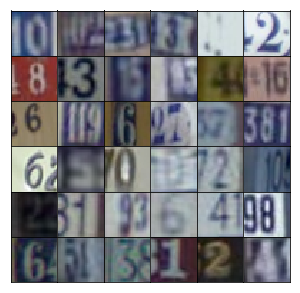

In [4]:
print("Number of training data: {}".format(trainset['X'].shape[3]))
print("Number of testing data: {}".format(testset['X'].shape[3]))

idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

### Data preprocessing

- First, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. 
- We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [5]:
class Dataset(object):
    """"""
    def __init__(self, train, test, val_frac=0.5, shuffle=False):
        """"""
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        """Batch generator for the training data"""
        if self.shuffle is True:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        # Scale the features to the range [-1, 1]
        scaler = lambda x: x/127.5 - 1
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii + batch_size]
            y = self.train_y[ii:ii + batch_size]
            
            yield scaler(x), y

## Generator

Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](images/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3.

In [6]:
def model_inputs(real_shape, z_size):
    """Placeholders of inputs for discriminator and generator"""
    inputs_real = tf.placeholder(tf.float32, (None, *real_shape), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_size), name='input_z')
    
    return inputs_real, inputs_z

In [7]:
def generator(z, real_shape, reuse=False, training=True):
    """Generator
    
    As suggested by the original paper, use ReLU for the generator.

    :param z: 1D array like
        Latent sample.
    :param real_shape: 1D array like
        Shape of the real data.
    :param reuse: boolean
        'reuse' indicator in tf.variable_scope()
    :training: boolean
        Indicate for batch_normalization in training and predicting
        
    :return: tensor having the same shape as the real data.
    """
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        X = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        X = tf.reshape(X, (-1, 4, 4, 512))
        X = tf.layers.batch_normalization(X, training=training)
        X = tf.nn.relu(X)
        # 4x4x512 now
        
        X = tf.layers.conv2d_transpose(X, 256, 5, strides=2, padding='same')
        X = tf.layers.batch_normalization(X, training=training)
        X = tf.nn.relu(X)
        # 8x8x256 now
        
        X = tf.layers.conv2d_transpose(X, 128, 5, strides=2, padding='same')
        X = tf.layers.batch_normalization(X, training=training)
        X = tf.nn.relu(X)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(X, real_shape[2], 5, strides=2, padding='same')
        # 32x32x3 now
        
        output = tf.tanh(logits)
        
        return output

## Discriminator

The discriminator is basically just a convolutional classifier. The input to the discriminator are 32x32x3 images.

In [8]:
def discriminator(x, reuse=False, alpha=0.2):
    """Discriminator
    
    As suggested by the original paper, use Leaky ReLU for the discriminator,
    and use strided convolutional layer to replace pooling layer.
    
    :param x: numpy.ndarray()
        Real or fake data.
    :param reuse: boolean
        'reuse' indicator in tf.variable_scope()
    :param alpha: float
        Slope of the leak in Leaky ReLU.
        
    :return: (output, logits). Each is a single number.
    """
    leaky_relu = lambda x, alpha : tf.maximum(alpha*x, x)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        X = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        X = leaky_relu(X, alpha)
        # 16x16x64
        
        X = tf.layers.conv2d(X, 128, 5, strides=2, padding='same')
        X = tf.layers.batch_normalization(X, training=True)
        X = leaky_relu(X, alpha)
        # 8x8x128
        
        X = tf.layers.conv2d(X, 256, 5, strides=2, padding='same')
        X = tf.layers.batch_normalization(X, training=True)
        X = leaky_relu(X, alpha)
        # 4x4x256

        # Flatten it
        X = tf.reshape(X, (-1, 4*4*256))
        logits = tf.layers.dense(X, 1)
        output = tf.sigmoid(logits)
        
        return output, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [9]:
def model_loss(x, z, alpha=0.2):
    """Loss for the discriminator and generator
    
    :param x: numpy.ndarray()
        Real data.
    :param z: 1D array like
        Latent samples.
    :param alpha: float
        Slope of the leak in Leaky ReLU.
    
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(z, x.get_shape().as_list()[1:])
    d_model_real, d_logits_real = discriminator(x, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    return d_loss, g_loss

## Optimizer
As suggested by the original paper, we should set 0.5 to $\beta_1$ instead of the default value 0.9.

In [10]:
def optimizer(d_loss, g_loss, learning_rate, beta1):
    """Get optimization operations
    
    :param d_loss: Tesor
        Discriminator loss.
    :param g_loss: Tensor
        Generator loss.
    :param learning_rate: float
        Learning rate.
    :param beta1: float
        The exponential decay rate for the 1st moment in the Adam optimizer.
    
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

In [11]:
class GAN(object):
    """The DCGAN model"""
    def __init__(self, real_shape, z_size, learning_rate, alpha=0.2, beta1=0.5):
        """Initialization"""
        tf.reset_default_graph()

        self.real_shape = real_shape
        self.input_real, self.input_z = model_inputs(real_shape, z_size)
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, alpha=alpha)
        self.d_opt, self.g_opt = optimizer(self.d_loss, self.g_loss, learning_rate, beta1)

## Predictor

In [12]:
def predict(sess, model, latent_samples):
    """Predict a batch of randomly generated latent samples
    
    :param sess: Tensorflow.Session() object
        Current session.
    :param model: GAN object
        GAN model.
    :param latent_samples: list of 1D array like.
        Input latent samples.
        
    :return: generated fake data.
    """
    g_model = generator(model.input_z, model.real_shape, reuse=True, training=False)
    gen_data = sess.run(g_model, feed_dict={model.input_z: latent_samples})
    
    return gen_data

## Train model

In [13]:
def train(model, dataset, epochs, batch_size, k=1, print_every=100, predict_every=5):
    """Train the model
    
    :param model: GAN object
        GAN model.
    :param dataset: Dataset object
        Data generator
    :param epochs: int
        Number of epochs to train.
    :param batch_size: int
        Batch size
    :param k: int
        Optimize the generator every k steps of optimizing the discriminator.
    :param print_every: int
        Interval of mini batches to print training loss.
    :param predict_every: int
        Interval of epochs to generate fake data.
        
    :return losses: list
        Loss history.
    :return fake_data: list of numpy.ndarray()
        Generated fake data at different training stages.
    """
    fake_data, losses = [], []
    steps = 0

    with tf.Session() as sess:
        
        if not os.path.exists('./checkpoints/generator.ckpt.meta'):
            # Use the same latent samples for illustrate the fake_data evolution 
            # after different epochs
            sample_z = np.random.uniform(-1, 1, size=(72, z_size))

            sess.run(tf.global_variables_initializer())
            for e in range(epochs):
                for x, y in dataset.batches(batch_size):
                    steps += 1

                    # Sample random noise for G
                    batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                    # Run optimizers
                    _, train_loss_d = sess.run([model.d_opt, model.d_loss], 
                                               feed_dict={model.input_real: x, model.input_z: batch_z})
                    
                    if steps % k == 0:
                        batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                        # We do not need model.input_real to train the generator, but we still need to 
                        # feed it into the graph to avoid error.
                        _, train_loss_g = sess.run([model.g_opt, model.g_loss], 
                                                   feed_dict={model.input_real: x, model.input_z: batch_z})
                        
                        losses.append((train_loss_d, train_loss_g))
                    
                    if steps % print_every == 0:
                        print("Epoch {}/{}...".format(e+1, epochs),
                              "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g))
         
                # Generate sample outputs every 5 epoches and at the last epoch
                if e % predict_every == 0 or e == epochs - 1:
                    fake_data.append(predict(sess, model, sample_z))

            saver.save(sess, './checkpoints/generator.ckpt')
    
    return losses, fake_data

In [14]:
real_shape = (32, 32, 3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 30
alpha = 0.2
beta1 = 0.5
k = 2

model = GAN(real_shape, z_size, learning_rate, alpha=alpha, beta1=beta1)

dataset = Dataset(trainset, testset)

saver = tf.train.Saver()

losses, fake_data = train(model, dataset, epochs, batch_size, k=2)

Epoch 1/30... Discriminator Loss: 0.0835... Generator Loss: 8.5611
Epoch 1/30... Discriminator Loss: 0.0204... Generator Loss: 6.5058
Epoch 1/30... Discriminator Loss: 0.6597... Generator Loss: 4.5501
Epoch 1/30... Discriminator Loss: 0.1207... Generator Loss: 4.1055
Epoch 1/30... Discriminator Loss: 0.8903... Generator Loss: 5.7910
Epoch 2/30... Discriminator Loss: 0.1268... Generator Loss: 4.6095
Epoch 2/30... Discriminator Loss: 0.2365... Generator Loss: 4.7128
Epoch 2/30... Discriminator Loss: 0.1957... Generator Loss: 3.6580
Epoch 2/30... Discriminator Loss: 0.1305... Generator Loss: 5.3562
Epoch 2/30... Discriminator Loss: 3.2766... Generator Loss: 3.6606
Epoch 2/30... Discriminator Loss: 0.3831... Generator Loss: 3.2076
Epoch 3/30... Discriminator Loss: 0.4435... Generator Loss: 5.0166
Epoch 3/30... Discriminator Loss: 0.3667... Generator Loss: 2.5650
Epoch 3/30... Discriminator Loss: 0.1398... Generator Loss: 3.4204
Epoch 3/30... Discriminator Loss: 0.5037... Generator Loss: 3.

Epoch 22/30... Discriminator Loss: 0.3378... Generator Loss: 3.0509
Epoch 22/30... Discriminator Loss: 1.3617... Generator Loss: 1.4426
Epoch 22/30... Discriminator Loss: 0.2831... Generator Loss: 2.7986
Epoch 22/30... Discriminator Loss: 0.1187... Generator Loss: 4.1818
Epoch 23/30... Discriminator Loss: 0.0615... Generator Loss: 4.5233
Epoch 23/30... Discriminator Loss: 0.1742... Generator Loss: 2.6479
Epoch 23/30... Discriminator Loss: 0.6281... Generator Loss: 3.5502
Epoch 23/30... Discriminator Loss: 0.2100... Generator Loss: 3.1464
Epoch 23/30... Discriminator Loss: 0.3814... Generator Loss: 1.2627
Epoch 24/30... Discriminator Loss: 0.2997... Generator Loss: 2.1945
Epoch 24/30... Discriminator Loss: 0.3958... Generator Loss: 3.9895
Epoch 24/30... Discriminator Loss: 0.2675... Generator Loss: 2.8834
Epoch 24/30... Discriminator Loss: 0.1774... Generator Loss: 2.5706
Epoch 24/30... Discriminator Loss: 0.2130... Generator Loss: 2.9464
Epoch 24/30... Discriminator Loss: 0.1563... Gen

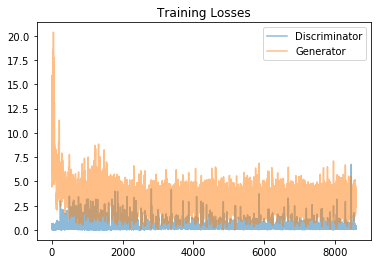

In [15]:
# Plot the loss history
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Visualize result

In [16]:
def view_data(epoch, fake_data, nrows=6, ncols=12, figsize=(10, 5)):
    """Visualize generated fake data"""
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), fake_data[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)

INFO:tensorflow:Restoring parameters from ./checkpoints/generator.ckpt


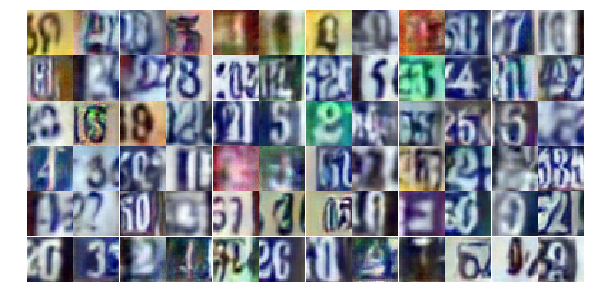

In [17]:
# Generate fake data with random latent samples
with tf.Session() as sess:
    saver.restore(sess, './checkpoints/generator.ckpt')
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))
    view_data(0, [predict(sess, model, sample_z)])

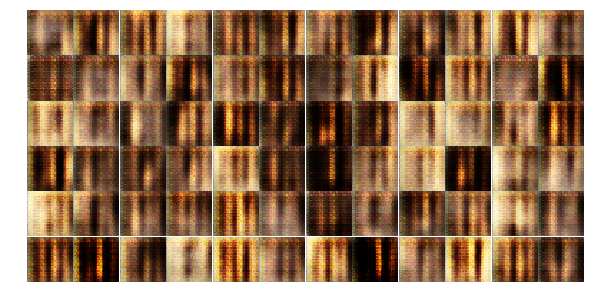

In [18]:
# Initial noise
_ = view_data(0, fake_data)

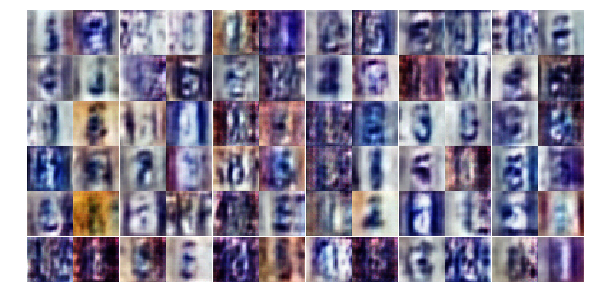

In [19]:
_ = view_data(1, fake_data)

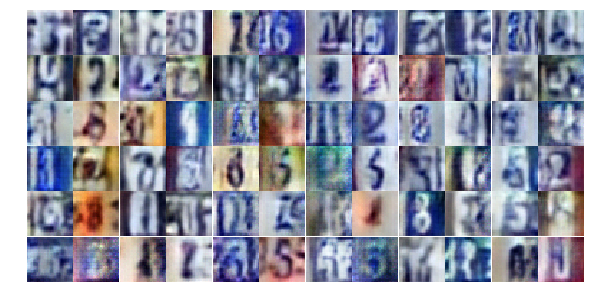

In [20]:
_ = view_data(2, fake_data)

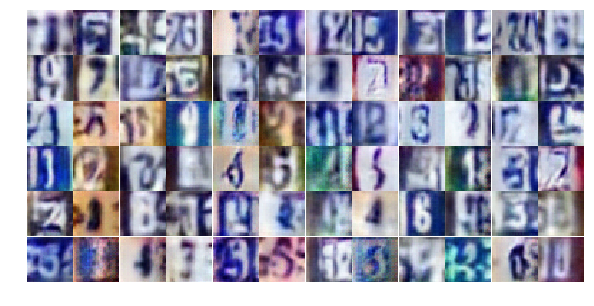

In [21]:
_ = view_data(3, fake_data)

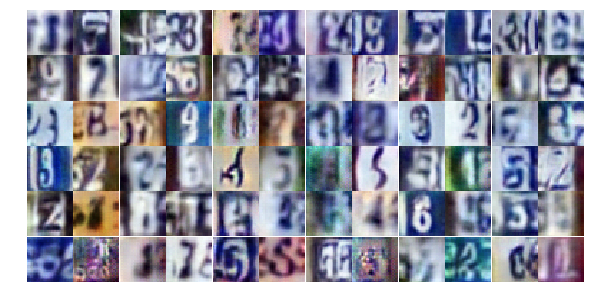

In [22]:
_ = view_data(4, fake_data)

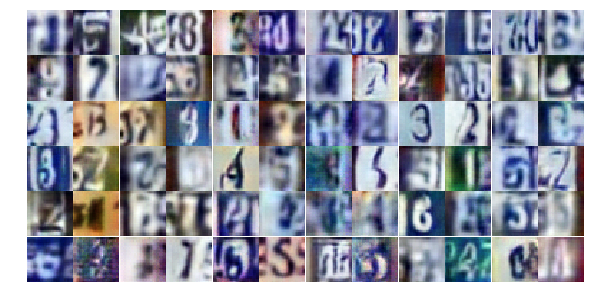

In [23]:
_ = view_data(5, fake_data)

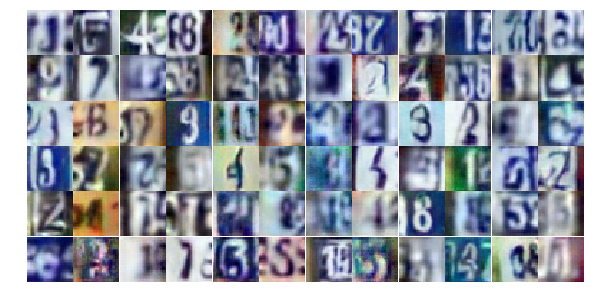

In [24]:
# Final output
_ = view_data(-1, fake_data)